# Semantic Segmentation with Attention U-net
The code cells below are essentially the same as in the previous U-net notebook (https://github.com/cstckr/semantic_segmentation_u-net/blob/main/u-net.ipynb) except that in this notebook attention gates are incorporated into the U-net architecture as described first by Oktay et al. (https://arxiv.org/pdf/1804.03999.pdf). For this, some additonal imports in code cell 1 are necessary. In code cell 8, the new attention U-net architecture is defined that now uses TensorFlow's functional API. 

In this notebook we will use the U-net architecture to predict which pixels in images of hippocampus sections belong to mitochondria. This type of problem set is termed semantic segmentation and the U-net (as introduced by Ronnenberger et al. (www.arxiv.org/abs/1505.04597)) is a useful convolutional neural network architecture to approach the problem of semantic segmentation. The image data used in this notebook can be download from following website: www.epfl.ch/labs/cvlab/data/data-em/. We will first load the image data and then normalize:

In [1]:
import random 
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Concatenate, Add, Activation, Multiply

tf.random.set_seed(42)

# Load image data and normalize
file_path_train = ".//training.tif"
file_path_train_mask = ".//training_groundtruth.tif"
file_path_test = ".//testing.tif"
file_path_test_mask = ".//testing_groundtruth.tif"

train = io.imread(file_path_train)
train_mask = io.imread(file_path_train_mask)
test = io.imread(file_path_test)
test_mask = io.imread(file_path_test_mask)

train = np.expand_dims(train / 255, 3)
train_mask = np.expand_dims(train_mask / 255, 3)
test = np.expand_dims(test / 255, 3)
test_mask = np.expand_dims(test_mask / 255, 3)

Let's quickly visualize one image and verify that the corresponding mask belongs to the same image:

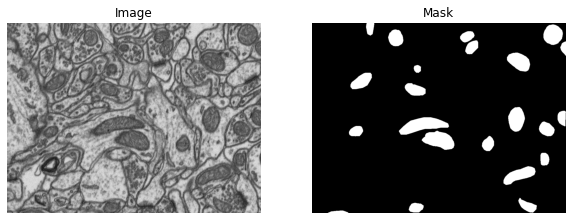

In [2]:
fig, ax = plt.subplots(1,2, figsize=(10, 8))
ax[0].imshow(train[0], cmap="gray")
ax[0].set_title("Image")
ax[1].imshow(train_mask[0], cmap="gray")
ax[1].set_title("Mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

The training data only contains 165 images. In addition to the small number of training images, these images represent consecutive slices taken from the hippocampus region of the brain. Therefore, some of the images are relatively similiar. To avoid overfitting, it is consequently advisable to augment the training images. We will do so by rotating, flipping, stretching, and zooming in. For our needs, the augmentation procedure has to be exactly the same for each image/mask pair. We will use the albumentations package (www.albumentations.ai) for this as it offers useful functionality for this scenario. We create 330 augmented training images by the code cell shown below:

In [3]:
transform = A.Compose([A.Rotate(30, p=0.5),
                       A.HorizontalFlip(p=0.5),
                       A.VerticalFlip(p=0.5),
                       A.RandomCrop(width=int(train.shape[2] * random.uniform(0.85, 1)), 
                                    height=int(train.shape[1] * random.uniform(0.85, 1))),
                       A.Resize(train.shape[1], train.shape[2])])

train_augmented = np.zeros((train.shape[0] * 3, train.shape[1], train.shape[2], train.shape[3]))
train_augmented[0:train.shape[0]] = train
train_mask_augmented = np.zeros((train_mask.shape[0] * 3, 
                                 train_mask.shape[1], 
                                 train_mask.shape[2], 
                                 train_mask.shape[3]))
train_mask_augmented[0:train_mask.shape[0]] = train_mask

indices = list(zip(range(train.shape[0], train_augmented.shape[0]), [k for k in range(0, train.shape[0]) for _ in range(2)]))
for i in indices:
    transformed = transform(image=train[i[1]], mask=train_mask[i[1]])
    train_augmented[i[0]] = transformed["image"]
    train_mask_augmented[i[0]] = transformed["mask"]

Let's quickly visualize that augmentation was succesful and that the masks fit to the augmented images:

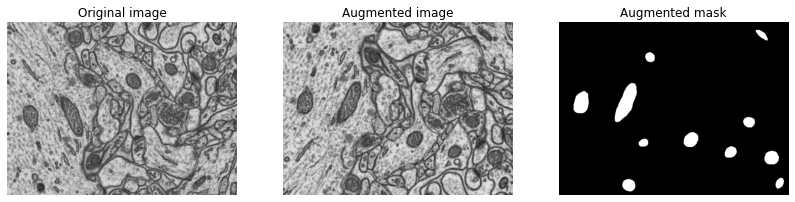

In [4]:
fig, ax = plt.subplots(1,3, figsize=(14, 8))
ax[0].imshow(train[-1], cmap="gray")
ax[0].set_title("Original image")
ax[1].imshow(train_augmented[-1], cmap="gray")
ax[1].set_title("Augmented image")
ax[2].imshow(train_mask_augmented[-1], cmap="gray")
ax[2].set_title("Augmented mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

Training segmentation tasks on large images can be very resource intensive. Therefore, the class in the next code cell implements functionality that allows for creation of smaller patches from larger images. It also implements functionality that predicts on these patches (if given a previously trained model) and then reassembles the predicted mask to the image shape of the original input image. We will use the latter functionality at a later stage of this notebook and just create patches for now:  

In [5]:
class PatchPredictReassemble():
    """
    This class is concerned with slicing a larger image into smaller patches, predicting if pixels in those patches belong
    to the target class, and subsequently reassembling those predicted patch masks to masks that fit the original input 
    image shape.
        
    Overview of Methods
    -------
    create_image_patches
    predict_on_patches
    reassemble
    """
        
    def __init__(self, images):
        """
        Parameters
        ----------
        images: numpy.array
            Input image data with following shape: (number of images, image height in pixel, image width in pixel, number of 
            channels).
        """
            
        self.images = images
        self.patched_images = images
        self.patch_size = images.shape[1:3]

    def create_image_patches(self, patch_size):
        """
        Creates smaller patches from larger images.
        
        Parameters
        ----------
        patch_size: tuple
            Size of the patches that are to be returned. Format: (image height in pixel, image width in pixel).
        
        Returns
        -------
        patched_images: numpy.array
            Patches created from the images.
        """
        
        self.patch_size = patch_size
        self.no_of_patches_along_y = self.images.shape[1] / self.patch_size[0]
        self.no_of_patches_along_x = self.images.shape[2] / self.patch_size[1]

        
        check_patch_size = [i.is_integer() for i in [self.no_of_patches_along_x, self.no_of_patches_along_y]]
        if all(check_patch_size):
            self.no_of_patches_along_x = int(self.no_of_patches_along_x)
            self.no_of_patches_along_y = int(self.no_of_patches_along_y)
        else:
            raise ValueError("Please use patch size values that allow dividing the image without creating overlapping patches.")

        self.patched_images = np.zeros((self.images.shape[0] * self.no_of_patches_along_x * self.no_of_patches_along_y, 
                                        self.patch_size[0], 
                                        self.patch_size[1], 1))
                
        counter = 0
        for i in range(0, self.images.shape[0]):    
            for j in range(0, self.no_of_patches_along_x):
                x_lower_patch_idx = j * self.patch_size[1]
                x_upper_patch_idx = (j + 1) * self.patch_size[1]
            
                for k in range(0, self.no_of_patches_along_y):
                    y_lower_patch_idx = k * self.patch_size[0]
                    y_upper_patch_idx = (k + 1) * self.patch_size[0]                    
                    self.patched_images[counter] = self.images[i][y_lower_patch_idx:y_upper_patch_idx,
                                                                  x_lower_patch_idx:x_upper_patch_idx, :]
                    counter += 1
        return self.patched_images

    def predict_on_patches(self, model, cutoff=0.5):
        """
        Predicts if a pixel in a given patch belong to the target class and returns the corresponding predicted mask.
        
        Parameters
        ----------
        model: 
            A model that features a predict method that if feed with the patches stored in the "patched_images" attribute
            returns probabilities for each pixel that indicate if that pixel belongs to the target class.
        
        cutoff: float
            Predicted probabilities larger than the cutoff value are converted to 1, meaning the pixel is assigned to the 
            target class.
            Predicted probabilities lower than the cutoff value are converted to 0, meaning the pixel is not assigned to the
            target class.
        """
        
        self.model = model
        self.predictions = self.model.predict(self.patched_images)
        self.predictions = np.where(self.predictions > cutoff, 1, 0)
    
    def reassemble(self):
        """
        Reassembles the predicted masks from the predicted patches (="predictions" attribute) so that they fit the shape 
        of the original input image data (="images" attribute).
        
        Returns
        -------
        reassembled_predictions: numpy.array
            Predicted masks for each of the original input images.
        """
                
        self.reassembled_predictions = np.zeros(
            (self.predictions.shape[0] // (self.no_of_patches_along_x * self.no_of_patches_along_y),
             (self.patch_size[0] *  self.no_of_patches_along_y), 
             (self.patch_size[1] *  self.no_of_patches_along_x), 
             1))
        
        counter = 0
        for i in range(0, self.reassembled_predictions.shape[0]):
            for j in range(0, self.no_of_patches_along_x):
                x_lower_patch_idx = j * self.patch_size[1]
                x_upper_patch_idx = (j + 1) * self.patch_size[1]

                for k in range(0, self.no_of_patches_along_y):
                    y_lower_patch_idx = k * self.patch_size[0]
                    y_upper_patch_idx = (k + 1) * self.patch_size[0]
                    self.reassembled_predictions[i, 
                                                   y_lower_patch_idx:y_upper_patch_idx,
                                                   x_lower_patch_idx:x_upper_patch_idx] = self.predictions[counter]
                    counter += 1
        return self.reassembled_predictions

The original images have a (768, 1024) px shape. We will create (256 x 256) px patches from the image data:

In [6]:
patch_size = (256, 256)

train_patches = PatchPredictReassemble(train_augmented).create_image_patches(patch_size)
train_mask_patches = PatchPredictReassemble(train_mask_augmented).create_image_patches(patch_size)
test_patches = PatchPredictReassemble(test).create_image_patches(patch_size)
test_mask_patches = PatchPredictReassemble(test_mask).create_image_patches(patch_size)

Let's visualize that creation of patches was succesful for both images and corresponding masks:

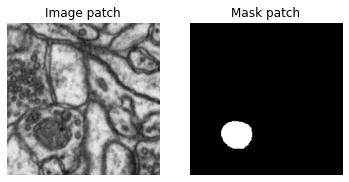

In [7]:
fig, ax = plt.subplots(1,2, figsize=(6, 4))
ax[0].imshow(train_patches[-2], cmap="gray")
ax[0].set_title("Image patch")
ax[1].imshow(train_mask_patches[-2], cmap="gray")
ax[1].set_title("Mask patch")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

Now, we will construct our attention U-net architecture:

In [8]:
def attention_u_net(input_shape, seed):
    inputs = Input(shape=input_shape)
    initializer = tf.keras.initializers.HeNormal(seed=seed)
    
    
    def conv_block(x, filters, pooling):
        if pooling:
            x = MaxPooling2D((2, 2))(x)
            x = BatchNormalization()(x)  
        x = Conv2D(filters, (3, 3), strides=(1, 1), activation="relu", padding="same", kernel_initializer=initializer)(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters, (3, 3), strides=(1, 1), activation="relu", padding="same", kernel_initializer=initializer)(x)
        return x
  

    def upsampling_block(x):
        x = UpSampling2D(interpolation="bilinear")(x)
        x = BatchNormalization()(x)
        return x
    
    
    def attention_gate(g, x):
        no_of_sigmoid1_filters = x.shape[3]
        sigmoid1 = Activation("relu")(
            Add()([Conv2D(no_of_sigmoid1_filters, (1, 1), strides=(2, 2), padding="same", 
                          kernel_initializer=initializer)(x),
                   Conv2D(no_of_sigmoid1_filters, (1, 1), strides=(1, 1), padding="same", 
                          kernel_initializer=initializer)(g)
                  ])
        )   
        sigmoid1 = BatchNormalization()(sigmoid1)
        sigmoid2 = Conv2D(1, (1, 1), activation="sigmoid", padding="same", kernel_initializer=initializer)(sigmoid1)
        sigmoid2 = BatchNormalization()(sigmoid2)
        alpha = UpSampling2D(interpolation="bilinear")(sigmoid2)
        x_hat = Multiply()([x, alpha])
        x_hat = BatchNormalization()(x_hat)
        return x_hat

    
    # Contraction
    c1 = conv_block(x=inputs, filters=16, pooling=False)
    c2 = conv_block(x=c1, filters=32, pooling=True)
    c3 = conv_block(x=c2, filters=64, pooling=True)
    
    # Bottleneck
    b1 = conv_block(x=c3, filters=128, pooling=True)
    
    # Expansion
    e3_b = upsampling_block(b1)
    a3 = attention_gate(b1, c3)
    e3_a = conv_block(x=Concatenate()([a3, e3_b]), filters=64, pooling=False)
    
    e2_b = upsampling_block(e3_a)
    a2 = attention_gate(e3_a, c2)
    e2_a = conv_block(x=Concatenate()([a2, e2_b]), filters=32, pooling=False)
    
    e1_b = upsampling_block(e2_a)
    a1 = attention_gate(e2_a, c1)
    e1_a = conv_block(x=Concatenate()([a1, e1_b]), filters=16, pooling=False)
    
    # Final
    outputs = Conv2D(1, (3, 3), activation="sigmoid", padding="same", kernel_initializer=initializer)(e1_a)

    # Get the model
    model = Model(inputs=inputs, outputs=outputs)
    
    tf.keras.utils.plot_model(model, to_file="attention_u-net.png", show_shapes=True)
#     model.summary()
    return model


unet2 = attention_u_net(input_shape=(256,256,1), seed=42)

Let's train the model and visualize the training progress:

In [9]:
unet2.compile(optimizer="adam", loss="binary_crossentropy")
es1 = callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5) 
history = unet2.fit(train_patches, train_mask_patches, 
                    epochs=50, batch_size=32, validation_data=(test_patches, test_mask_patches),
                    shuffle=True, verbose=1, callbacks=[es1])

Epoch 1/50
186/186 [==============================] - 2618s 14s/step - loss: 0.0736 - val_loss: 0.3558
Epoch 2/50
186/186 [==============================] - 2635s 14s/step - loss: 0.0301 - val_loss: 0.2152
Epoch 3/50
186/186 [==============================] - 2680s 14s/step - loss: 0.0247 - val_loss: 0.0447
Epoch 4/50
186/186 [==============================] - 2742s 15s/step - loss: 0.0212 - val_loss: 0.0477
Epoch 5/50
186/186 [==============================] - 2702s 15s/step - loss: 0.0191 - val_loss: 0.0347
Epoch 6/50
186/186 [==============================] - 2774s 15s/step - loss: 0.0179 - val_loss: 0.0447
Epoch 7/50
186/186 [==============================] - 2717s 15s/step - loss: 0.0169 - val_loss: 0.0393
Epoch 8/50
186/186 [==============================] - 2611s 14s/step - loss: 0.0155 - val_loss: 0.0371
Epoch 9/50
186/186 [==============================] - 2784s 15s/step - loss: 0.0148 - val_loss: 0.0314
Epoch 10/50
186/186 [==============================] - 2764s 15s/step - l

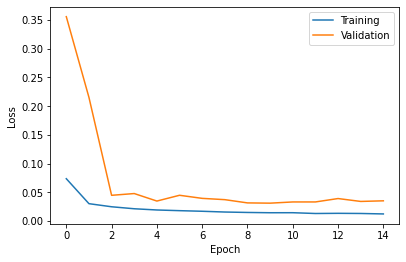

In [10]:
fig, ax = plt.subplots()
ax.plot(history.history["loss"], label="Training")
ax.plot(history.history["val_loss"], label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.tight_layout(pad=2.0)
plt.show()

Because training takes significant time, we will save the model:

In [12]:
unet2.save(".\\unet2")

C:\Users\User\.conda\envs\DL\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: .\unet2\assets


And are now able to load the trained model:

In [13]:
unet2 = tf.keras.models.load_model(".\\unet2", compile=False)

Now, let's predict on the test set images:

In [14]:
ppr5 = PatchPredictReassemble(test)
ppr5.create_image_patches(patch_size)
ppr5.predict_on_patches(unet2)
test_predictions = ppr5.reassemble()

Let's visualize how good our prediction correspond to the actual mitochondria:

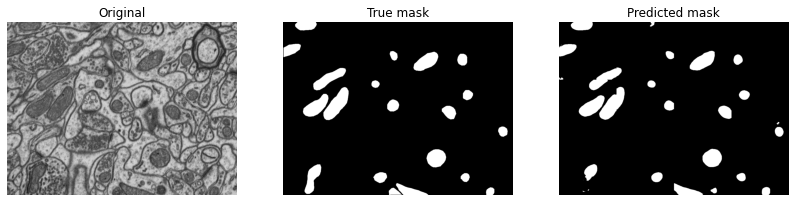

In [15]:
fig, ax = plt.subplots(1,3, figsize=(14, 8))
ax[0].imshow(test[0], cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(test_mask[0], cmap="gray")
ax[1].set_title("True mask")
ax[2].imshow(test_predictions[0], cmap="gray")
ax[2].set_title("Predicted mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

Finally, we calculate the mean intersection-over-union metric for all the test set predictions:

In [18]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(test_mask, test_predictions)
print(f"The mean intersection-over-union score for the test set is: {m.result().numpy()}")

The mean intersection-over-union score for the test set is: 0.8813599944114685
